In [2]:
import math
import numpy as np
import os
import pandas as pd
import pysurvival
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from statistics import mean, stdev

from pysurvival.utils.display import correlation_matrix
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index, integrated_brier_score

from sklearn.model_selection import StratifiedKFold, KFold

from statsmodels.stats.outliers_influence import variance_inflation_factor

from lifelines import CoxPHFitter
import lifelines

# from sksurv.metrics import concordance_index_censored, concordance_index_ipcw

In [ ]:
# Only need to run this once
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages("survAUC")

### Feature Selection

In [4]:
def cox_feature_select(X, t, e):
    num_samples = X.shape[0]
    num_events = sum(e)

    data_table = X
    data_table['Time'] = t
    data_table['Event'] = e

    max_num_features = math.ceil(num_events/10)
    cph = CoxPHFitter()
    cph.fit(data_table, duration_col='Time', event_col='Event')

    hr = abs(cph.params_)
    
    filtered_hr = hr.nlargest(n=max_num_features, keep='first')
    index_names = filtered_hr.index

    col_names = []
    for x in range(1, len(index_names)):
        col_names.append(index_names[x])

    filtered_X = X.filter(items=col_names, axis=1)
    print("Cox filter remaining variables: \n", filtered_X.columns)

    return filtered_X

In [5]:
def calculate_vif(X, thresh=10):
    variables = list(range(X.shape[1]))
    dropped=True

    while dropped:
        dropped=False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix) \
               for ix in range(X.iloc[:, variables].shape[1])]
    
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            # print("Dropping \'" + X.iloc[:, variables].columns[maxloc] + "\' at index: "+ str(maxloc))
            del variables[maxloc]
            dropped = True
    
    print('VIF remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]
        


### Model Creation and Training

In [4]:
def gh_c_index(risk_pred):
    """
    Calculate Gonen and Hiller's c-index using function from R (using rpy2) 

    Args:
        risk_pred: np.ndarray or torch.Tensor, risk score predictions from model

    Source: Gonen, M. and G. Heller (2005). 
    Concordance probability and discriminatory power in proportional hazards regression.
    Biometrika 92, 965–970.
    """

    # check for NaNs
    if not isinstance(risk_pred, np.ndarray):
        risk_pred = risk_pred.detach().cpu().numpy()
    for a in risk_pred:
        if np.isnan(a).any():
            raise ValueError("NaNs detected in inputs, please correct or drop.")

    # Use Gonen and Hiller's c-index via the survAUC library in R
    survAUC = rpackages.importr('survAUC')

    # Get data into right format
    R_risk_pred = robjects.vectors.FloatVector(risk_pred)

    # this doesn't work yet, need to get the list to numeric type
    # in R, this is accomplished with as.numeric and unlist()
    R_cind = survAUC.GHCI(R_risk_pred)

    # Convert back to Python list with single value
    cind = list(R_cind)

    # Return the only value in the cind list
    return cind[0]

In [6]:
def train_survival_model(X, t, e, num_trees, max_depth, min_node_size, seed=16):
    """
    Function to create and run Random Survival Forest with given attributes on data.

    Args:
        X: array -- input features, rows as samples
        t: array -- time labels for X, when event of interest or censoring occurred
        e: array -- event labels for X, if event occurred (1=event, 0=censoring)
        num_trees: int -- number of trees that will be built in forest model, used in initialization of model
        max_depth: int -- maximum number of levels allowed in tree, used in model fit
        min_node_size: int -- minimum number of samples required to be at leaf node, used in model fit
        seed: int -- random seed used by random number generator in model fit

    Returns: 
        rsf: pysurvival.model.RandomSurvivalForestModel -- model fit to input data
    """

    # Create instance of the model
    rsf = RandomSurvivalForestModel(num_trees=num_trees)

    # Fit model to data
    # Arguments not used from function input are defaults except importance_mode
    # TODO: need to find out what importance mode is 
    rsf.fit(X, t, e, max_features='all', max_depth=max_depth, min_node_size=min_node_size,
            num_threads=-1, sample_size_pct=0.63,
            seed=seed, save_memory=False)


    return rsf

In [7]:
def evaluate_forest(rsf, XT, tT, eT):
    bool_eT = eT.astype('bool')

    risk = rsf.predict_risk(XT)
    # h_c_ind = concordance_index_censored(bool_eT, tT, risk) # add [0] to h_c_ind in return line
    h_c_ind = lifelines.utils.concordance_index(tT, risk, eT)
    u_c_stat = concordance_index(rsf, XT, tT, eT)
    # gh_c_ind = gh_c_index(risk)
    ibs = integrated_brier_score(rsf, XT, tT, eT)

    return h_c_ind, u_c_stat, ibs, risk


In [13]:
def kfold_train_survival_model(X, t, e, num_trees, max_depth, min_node_size, k=5, seed=16):
    CI = []
    CPE = []
    IBS = []

    best_fold = 0
    best_CI = 0
    # best_GHCI = 0
    # best_IBS = 0 
    best_fold_rsf = None

    kf = StratifiedKFold(n_splits=k, random_state=seed, shuffle=True)

    history = {'train_CI': [], 'train_UnoC': [], 'train_IBS': [], 
               'valid_CI': [], 'valid_UnoC': [], 'valid_IBS': [],}
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, e)):
        # Output current fold number
        # print('Fold {}'.format(fold + 1))

        X_train, X_val = X.loc[train_idx], X.loc[val_idx]
        t_train, t_val = t.loc[train_idx], t.loc[val_idx]
        e_train, e_val = e.loc[train_idx], e.loc[val_idx]

        fold_rsf = train_survival_model(X_train, t_train, e_train, num_trees, max_depth, min_node_size, seed)

        train_h_c_ind, train_u_c_stat, train_ibs, train_risk_preds = evaluate_forest(fold_rsf, X_train, t_train, e_train)
        val_h_c_ind, val_u_c_stat, val_ibs, val_risk_preds = evaluate_forest(fold_rsf, X_val, t_val, e_val)

        # preds_and_labels = pd.DataFrame(train_risk_preds, columns=['Prediction'])

        history['train_CI'].append(train_h_c_ind)
        history['train_UnoC'].append(train_u_c_stat)
        history['train_IBS'].append(train_ibs)
        history['valid_CI'].append(val_h_c_ind)
        history['valid_UnoC'].append(val_u_c_stat)
        history['valid_IBS'].append(val_ibs)

        if best_CI < val_u_c_stat:
            best_CI = val_u_c_stat
            best_fold = fold
            best_fold_rsf = fold_rsf

    
    train_CI_avg = mean(history['train_CI'])
    train_CI_std = stdev(history['train_CI'])
    train_UnoC_avg = mean(history['train_UnoC'])
    train_UnoC_std = stdev(history['train_UnoC'])
    train_IBS_avg = mean(history['train_IBS'])
    train_IBS_std = stdev(history['train_IBS'])

    valid_CI_avg = mean(history['valid_CI'])
    valid_CI_std = stdev(history['valid_CI'])
    valid_UnoC_avg = mean(history['valid_UnoC'])
    valid_UnoC_std = stdev(history['valid_UnoC'])
    valid_IBS_avg = mean(history['valid_IBS'])
    valid_IBS_std = stdev(history['valid_IBS'])



    avg_train_fold_results = {'CI_avg': train_CI_avg, 'CI_std': train_CI_std, 
                              'UnoC_avg': train_UnoC_avg, 'UnoC_std': train_UnoC_std,
                              'IBS_avg': train_IBS_avg, 'IBS_std': train_IBS_std}

    avg_valid_fold_results = {'CI_avg': valid_CI_avg, 'CI_std': valid_CI_std, 
                              'UnoC_avg': valid_UnoC_avg, 'UnoC_std': valid_UnoC_std,
                              'IBS_avg': valid_IBS_avg, 'IBS_std': valid_IBS_std}

    best_fold_results = {'train_CI': history['train_CI'][best_fold],
                         'train_UnoC': history['train_UnoC'][best_fold],
                         'train_IBS': history['train_IBS'][best_fold],
                         'valid_CI': history['valid_CI'][best_fold],
                         'valid_UnoC': history['valid_UnoC'][best_fold],
                         'valid_IBS': history['valid_IBS'][best_fold]}

    return avg_train_fold_results, avg_valid_fold_results, best_fold_results, best_fold_rsf


# avg_train_fold_results, avg_valid_fold_results, best_fold_results, best_fold_rsf = \
#                     kfold_train_survival_model(X_liver, t_liver, e_liver, num_trees=10, max_depth=6, min_node_size=15, k=5, seed=16)

In [9]:
def gridsearch_survival_model(X, t, e, tree_search, depth_search, node_search):
    """
    Function to run a gridsearch on various Random Survival Forest hyperparameters

    Args:
        X: array -- input features, rows as samples
        t: array -- time labels for X, when event of interest or censoring occurred
        e: array -- event labels for X, if event occurred (1=event, 0=censoring)
    """
    # Values to search through
    num_tree=tree_search
    max_depth=depth_search
    min_node=node_search

    # initialize variables to store best options
    num_tree_best = 0
    max_depth_best = 0
    min_node_best = 0
    curr_c_index_best = 0
    cpe_best = 0
    # ghci_best = 0
    avg_train_results = None
    avg_valid_results = None
    best_overall_results = None
    best_rsf = None


    for a in num_tree:
        for b in max_depth:
            for c in min_node:
                avg_train_fold_results, avg_valid_fold_results, best_fold_results, best_fold_rsf = \
                    kfold_train_survival_model(X, t, e, num_trees=a, max_depth=b, min_node_size=c, k=5, seed=16)
                # print(best_fold_results['train_CI'], best_fold_results['valid_CI'])
                best_val_ci = best_fold_results['valid_UnoC']
                if best_val_ci > curr_c_index_best:
                    curr_c_index_best = best_val_ci
                    avg_train_results = avg_train_fold_results
                    avg_valid_results = avg_valid_fold_results
                    best_overall_results = best_fold_results
                    num_tree_best = a
                    max_depth_best = b
                    min_node_best = c
                    best_rsf = best_fold_rsf

    return num_tree_best, max_depth_best, min_node_best, avg_train_results, avg_valid_results, best_overall_results, best_rsf

# Main Script

### Liver

In [10]:
data_folder = "/Data/FeatureSelection/HCC_MCRC_ICC_HDFS_90_10/"

train_liver_data = pd.read_excel(os.path.join(data_folder, "train_liver_feats_and_labels.xlsx"))
test_liver_data = pd.read_excel(os.path.join(data_folder, "test_liver_feats_and_labels.xlsx"))

features_to_drop=[]
# features_to_drop = ['LeastAxisLength', '90Percentile', 'Contrast', 'MeshVolume', 'Complexity', 'MinorAxisLength', \
#                     '10Percentile', 'Uniformity', 'Mean', 'Energy', 'InterquartileRange', 'TotalEnergy', 'Busyness', \
#                     'RootMeanSquared', 'Maximum3DDiameter']

X_liver = train_liver_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
X_liver = X_liver.drop(labels=features_to_drop, axis=1)
t_liver = train_liver_data["HDFS_Time"]
e_liver = train_liver_data["HDFS_Code"]

XT_liver = test_liver_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
XT_liver = XT_liver.drop(labels=features_to_drop, axis=1)
tT_liver = test_liver_data["HDFS_Time"]
eT_liver = test_liver_data["HDFS_Code"]


# CI_avg, GHCI_avg, IBS_avg, best_CI, best_GHCI, best_IBS, best_fold_rsf = kfold_train_survival_model(\
#     X_liver, t_liver, e_liver, num_trees=5, max_depth=5, min_node_size=5, k=5, seed=16)


In [11]:
liver_vselected_features = calculate_vif(X_liver, 10)
X_liver = liver_vselected_features

X_liver = cox_feature_select(X_liver, t_liver, e_liver)


/opt/conda/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF remaining variables:
Index(['Kurtosis', 'Skewness', 'Variance', 'Busyness', 'Coarseness',
       'Complexity', 'Contrast', 'Strength', 'Flatness', 'SurfaceArea'],
      dtype='object')
Cox filter remaining variables: 
 Index(['Contrast', 'Flatness', 'Strength', 'Skewness', 'Kurtosis', 'Busyness',
       'Complexity', 'Variance', 'SurfaceArea'],
      dtype='object')


/opt/conda/lib/python3.8/site-packages/lifelines/utils/__init__.py:1103: ConvergenceWarning: Column(s) ['Coarseness', 'Contrast'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


In [12]:
X_liver.drop(labels=['Contrast'], inplace=True, axis=1)
print(X_liver.columns)

Index(['Flatness', 'Strength', 'Skewness', 'Kurtosis', 'Busyness',
       'Complexity', 'Variance', 'SurfaceArea'],
      dtype='object')


In [10]:
X_liver = X_liver.filter(items=['Skewness', 'SurfaceArea', 'Variance', 'Contrast', \
    'Kurtosis', 'Flatness', 'Complexity', 'Busyness', 'Strength'], axis=1)

In [11]:
avg_train_fold_results, avg_valid_fold_results, best_fold_results, best_fold_rsf = \
                    kfold_train_survival_model(X_liver, t_liver, e_liver, num_trees=10, max_depth=6, min_node_size=15, k=5, seed=16)

In [14]:
num_tree=(5, 10, 25, 50)
max_depth=(3, 5, 8, 10)
min_node=(5, 8, 10, 12, 15)


liv_num_tree_best, liv_max_depth_best, liv_min_node_best, \
    liv_avg_train_results, liv_avg_valid_results, liv_best_overall_results, liv_best_fold_rsf \
        = gridsearch_survival_model(X_liver, t_liver, e_liver, num_tree, max_depth, min_node)

print("Best valid c-index:", liv_best_overall_results['valid_CI'])
print("Best valid c-statistic", liv_best_overall_results['valid_UnoC'])
print("Best num_tree val:",liv_num_tree_best)
print("Best max_depth val:", liv_max_depth_best)
print("Best min_node val:",liv_min_node_best)

liver_h_c_ind, liver_u_c_stat, liver_ibs, liver_riskpreds = evaluate_forest(liv_best_fold_rsf, XT_liver, tT_liver, eT_liver)

print("Training: ")
print("Harrel's C-index: ", liv_best_overall_results['train_CI'])
print("Uno C-statistic: ", liv_best_overall_results['train_UnoC'])
print("IBS: ", liv_best_overall_results['train_IBS'])
print()

print("Validation: ")
print("Harrel's C-index: ", liv_best_overall_results['valid_CI'])
print("Uno C-statistic: ", liv_best_overall_results['valid_UnoC'])
print("IBS: ", liv_best_overall_results['valid_IBS'])

print()
print("Testing: ")
print("Harrel's C-index: ", liver_h_c_ind)
print("Uno C-statistic: ", liver_u_c_stat)
print("IBS: ", liver_ibs)

liv_var_imps = liv_best_fold_rsf.variable_importance_table
liv_var_imps

In [ ]:
print("Best valid c-index:", liv_best_overall_results['valid_CI'])
print("Best valid c-statistic", liv_best_overall_results['valid_UnoC'])
print("Best num_tree val:",liv_num_tree_best)
print("Best max_depth val:", liv_max_depth_best)
print("Best min_node val:",liv_min_node_best)

liver_h_c_ind, liver_u_c_stat, liver_ibs, liver_riskpreds = evaluate_forest(liv_best_fold_rsf, XT_liver, tT_liver, eT_liver)

print("Training: ")
print("Harrel's C-index: ", liv_best_overall_results['train_CI'])
print("Uno C-statistic: ", liv_best_overall_results['train_UnoC'])
print("IBS: ", liv_best_overall_results['train_IBS'])
print()

print("Validation: ")
print("Harrel's C-index: ", liv_best_overall_results['valid_CI'])
print("Uno C-statistic: ", liv_best_overall_results['valid_UnoC'])
print("IBS: ", liv_best_overall_results['valid_IBS'])

print()
print("Testing: ")
print("Harrel's C-index: ", liver_h_c_ind)
print("Uno C-statistic: ", liver_u_c_stat)
print("IBS: ", liver_ibs)

liv_var_imps = liv_best_fold_rsf.variable_importance_table
liv_var_imps

In [67]:
# bool_e_liver = e_liver.astype(dtype='bool')
# bool_eT_liver = eT_liver.astype(dtype='bool')

# pd_liver_train_survival = pd.concat([bool_e_liver, t_liver], axis=1)
# pd_liver_test_survival = pd.concat([bool_eT_liver, tT_liver],axis=1)

# liver_train_survival = sksurv.util.Surv.from_dataframe(event='HDFS_Code', time='HDFS_Time', data=pd_liver_train_survival)
# liver_test_survival = sksurv.util.Surv.from_dataframe(event='HDFS_Code', time='HDFS_Time', data=pd_liver_test_survival)

# # liver_train_survival
# concordance_index_ipcw(liver_train_survival, liver_test_survival, liver_riskpreds)
# liver_train_survival

(0.4953275945772519, 291, 295, 143, 1)

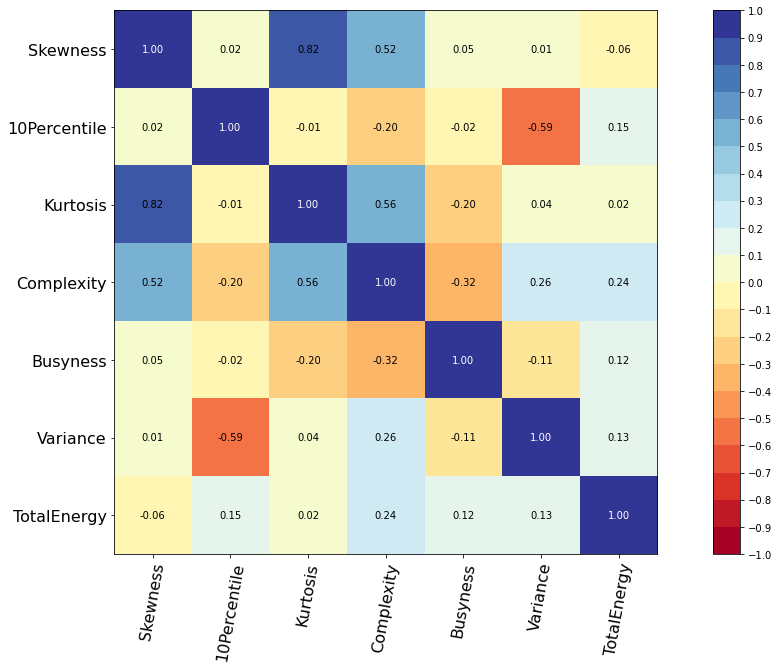

In [20]:
correlation_matrix(X_liver, figure_size=(20,10), text_fontsize=10)

In [22]:
test_liver_predictions = test_liver_data.loc[:, ['ScoutID', "HDFS_Time", "HDFS_Code", "Cancer_Type"]]
test_liver_predictions['Prediction'] = liver_riskpreds
test_liver_predictions.to_excel(os.path.join(data_folder, "RSF_test_liver_predictions_80_20_041922.xlsx"), index=False)

### Tumor

In [12]:
# Data Loading and Setup
data_folder = "/Data/FeatureSelection/HCC_MCRC_ICC_HDFS_90_10/"

train_tumor_data = pd.read_excel(os.path.join(data_folder, "train_tumor_feats_and_labels.xlsx"))
test_tumor_data = pd.read_excel(os.path.join(data_folder, "test_tumor_feats_and_labels.xlsx"))

features_to_drop = []
# features_to_drop = ['SurfaceVolumeRatio', 'Maximum2DDiameterSlice', 'MajorAxisLength', 'Busyness', 'VoxelVolume',\
                    # '90Percentile', 'Median', 'Energy', 'RootMeanSquared']

X_tumor = train_tumor_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
X_tumor = X_tumor.drop(labels=features_to_drop, axis=1)
t_tumor = train_tumor_data["HDFS_Time"]
e_tumor = train_tumor_data["HDFS_Code"]

XT_tumor = test_tumor_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
XT_tumor = XT_tumor.drop(labels=features_to_drop, axis=1)
tT_tumor = test_tumor_data["HDFS_Time"]
eT_tumor = test_tumor_data["HDFS_Code"]

In [11]:
# Feature selection
tum_vselected_features = calculate_vif(X_tumor, 10)
X_tumor = tum_vselected_features

X_tumor = cox_feature_select(X_tumor, t_tumor, e_tumor)


/opt/conda/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF remaining variables:
Index(['10Percentile', 'Kurtosis', 'Minimum', 'TotalEnergy', 'Busyness',
       'Coarseness', 'Complexity', 'Contrast', 'Strength', 'Flatness',
       'Maximum2DDiameterColumn', 'MeshVolume'],
      dtype='object')
Cox filter remaining variables: 
 Index(['Contrast', 'Flatness', 'Strength', 'Maximum2DDiameterColumn',
       '10Percentile', 'Kurtosis', 'Busyness', 'Complexity', 'Minimum',
       'MeshVolume', 'TotalEnergy'],
      dtype='object')


/opt/conda/lib/python3.8/site-packages/lifelines/utils/__init__.py:1103: ConvergenceWarning: Column(s) ['Coarseness'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


In [ ]:
X_tumor.drop(labels=['Minimum', 'Complexity', 'Busyness', 'Flatness', 'TotalEnergy', 'Kurtosis', 'MeshVolume'], inplace=True, axis=1)
X_tumor.columns

In [13]:
X_tumor = X_tumor.filter(items=['Kurtosis', 'TotalEnergy', 'Maximum2DDiameterColumn', '10Percentile', 'MeshVolume'], axis=1)

In [25]:
X_tumor

,Kurtosis,TotalEnergy,Maximum2DDiameterColumn,10Percentile,MeshVolume
0,7.744291,7461389,27.294688,90.7,510.916667
1,3.044719,50665756,48.010416,54.0,8761.458333
2,2.471021,442860546,76.105190,32.0,70864.583333
3,4.461884,289847608,57.035077,94.0,20776.750000
4,5.572456,374962845,57.008771,117.0,15678.875000
...,...,...,...,...,...
444,77.405511,107519374,64.280635,64.0,10493.041667
445,3.293966,80090272,44.045431,93.0,4899.375000
446,2.860962,554566701,130.003846,31.0,107445.500000
447,3.051396,11181922,20.024984,77.5,1076.791667


In [15]:
# num_tree=(5, 10, 15, 20, 25)
# max_depth=(2, 4, 6, 8, 10)
# min_node=(5, 8, 10, 12, 15)

tum_num_tree=(50, 100)
tum_max_depth=(5, 8, 10, 12, 15)
tum_min_node=(5, 8, 10, 12, 15)
# RSF Model creation and evaluation
tum_num_tree_best, tum_max_depth_best, tum_min_node_best, \
    tum_avg_train_results, tum_avg_valid_results, tum_best_overall_results, tum_best_fold_rsf \
        = gridsearch_survival_model(X_tumor, t_tumor, e_tumor, tum_num_tree, tum_max_depth, tum_min_node)

print("Best k-fold c-index:", tum_best_overall_results['valid_CI'])
# print(ghci_best)
print("Best num_tree val:",tum_num_tree_best)
print("Best max_depth val:", tum_max_depth_best)
print("Best min_node val:",tum_min_node_best)

# tumor_rsf = train_survival_model(X_tumor, t_tumor, e_tumor, num_trees=tum_num_tree_best, max_depth=tum_max_depth_best, min_node_size=tum_min_node_best, seed=16)
# train_tumor_cind, train_tumor_ghci, train_tumor_ibs, train_tumor_riskpred = evaluate_forest(tumor_rsf, X_tumor, t_tumor, e_tumor)
tumor_h_c_ind, tumor_u_c_stat, tumor_ibs, tumor_preds = evaluate_forest(tum_best_fold_rsf, XT_tumor, tT_tumor, eT_tumor)

print("Training: ")
print("Harrel's C-index: ", tum_best_overall_results['train_CI'])
print("Uno C-statistic: ", tum_best_overall_results['train_UnoC'])
print("IBS: ", tum_best_overall_results['train_IBS'])
print()

print("Validation: ")
print("Harrel's C-index: ", tum_best_overall_results['valid_CI'])
print("Uno's c-statistic: ", tum_best_overall_results['valid_UnoC'])
print("IBS: ", tum_best_overall_results['valid_IBS'])

print()
print("Testing: ")
print("Harrel's C-index: ", tumor_h_c_ind)
print("Uno's c-statistic: ", tumor_u_c_stat)
print("IBS: ", tumor_ibs)

tum_var_imps = tum_best_fold_rsf.variable_importance_table
tum_var_imps

Best k-fold c-index: 0.486328125
Best num_tree val: 50
Best max_depth val: 10
Best min_node val: 5
Training: 
Harrel's C-index:  0.17951648570079756
Uno C-statistic:  0.742163384412373
IBS:  0.14858114802450315

Validation: 
Harrel's C-index:  0.486328125
Uno's c-statistic:  0.5193106367862047
IBS:  0.23965492244293307

Testing: 
Harrel's C-index:  0.5308641975308642
Uno's c-statistic:  0.5204542802986132
IBS:  0.2991404901018981


,feature,importance,pct_importance
0,Maximum2DDiameterColumn,8.986200,0.807871
1,Kurtosis,1.539300,0.138385
2,MeshVolume,0.597805,0.053743
3,TotalEnergy,-0.127037,0.000000
4,10Percentile,-3.346885,0.000000


In [44]:
test_tumor_predictions = test_tumor_data.loc[:, ['ScoutID', "HDFS_Time", "HDFS_Code", "Cancer_Type"]]
test_tumor_predictions['Prediction'] = tumor_preds
test_tumor_predictions.to_excel(os.path.join(data_folder, "RSF_test_tumor_predictions_90_10_041922.xlsx"), index=False)

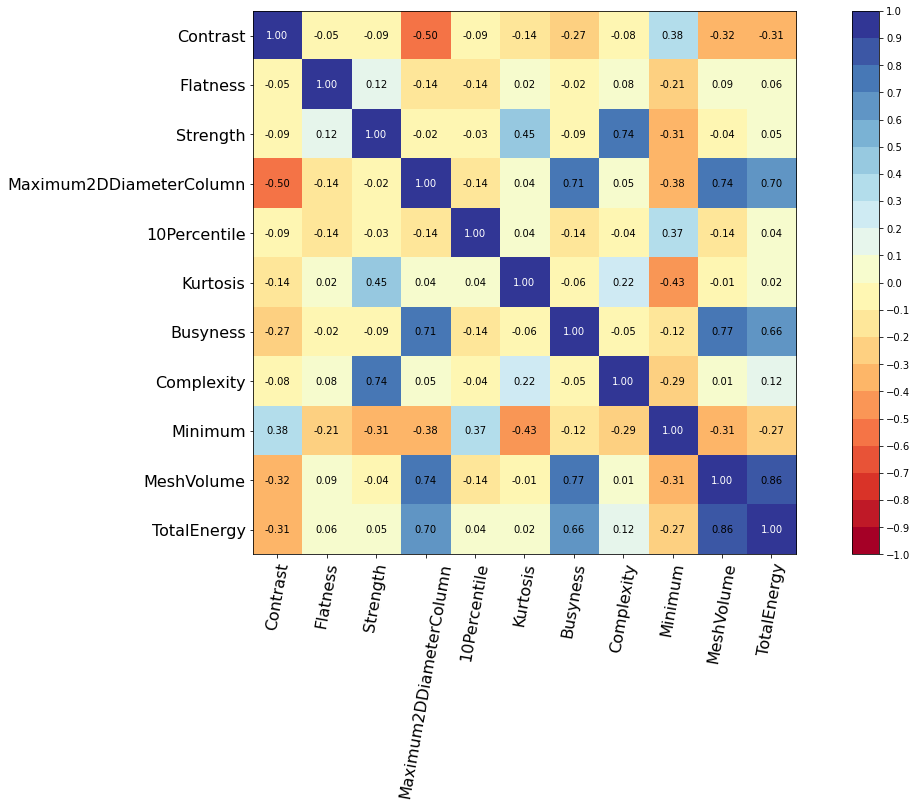

In [45]:
correlation_matrix(X_tumor, figure_size=(20,10), text_fontsize=10)

### Liver and Tumor

In [9]:
data_folder = "/Data/FeatureSelection/HCC_MCRC_ICC_HDFS_80_20/"

train_livertumor_data = pd.read_excel(os.path.join(data_folder, "train_liver_tumor_feats_and_labels.xlsx"))
test_livertumor_data = pd.read_excel(os.path.join(data_folder, "test_liver_tumor_feats_and_labels.xlsx"))

features_to_drop = []
# features_to_drop = ['Strength', 'MinorAxisLength', 'VoxelVolume', 'Complexity', 'Uniformity', 'Minimum', \
#                     'Median', 'InterquartileRange', 'Energy']

X_livertumor = train_livertumor_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
X_livertumor = X_livertumor.drop(labels=features_to_drop, axis=1)
t_livertumor = train_livertumor_data["HDFS_Time"]
e_livertumor = train_livertumor_data["HDFS_Code"]

XT_livertumor = test_livertumor_data.drop(labels=["ScoutID", "HDFS_Time", "HDFS_Code", "Cancer_Type"], axis=1)
XT_livertumor = XT_livertumor.drop(labels=features_to_drop, axis=1)
tT_livertumor = test_livertumor_data["HDFS_Time"]
eT_livertumor = test_livertumor_data["HDFS_Code"]

In [ ]:
livtum_vselected_features = calculate_vif(X_livertumor, 10)
X_livertumor = livtum_vselected_features

X_livertumor = cox_feature_select(X_livertumor, t_livertumor, e_livertumor)

In [24]:
X_livertumor.drop(labels=['Busyness'], inplace=True, axis=1)

In [10]:
X_livertumor = X_livertumor.filter(items=['Skewness', 'Strength', 'Variance', 'Complexity', 'SurfaceVolumeRatio', 'Kurtosis', 'TotalEnergy', 'Flatness'], axis=1)

In [11]:
livtum_num_tree=(5, 10, 15, 20, 25)
livtum_max_depth=(2, 4, 6, 8, 10)
livtum_min_node=(5, 8, 10, 12, 15)


livtum_num_tree_best, livtum_max_depth_best, livtum_min_node_best, \
    livtum_avg_train_results, livtum_avg_valid_results, livtum_best_overall_results, livtum_best_fold_rsf \
        = gridsearch_survival_model(X_livertumor, t_livertumor, e_livertumor, livtum_num_tree, livtum_max_depth, livtum_min_node)

print("Best k-fold c-index:", livtum_best_overall_results['valid_CI'])
# print(ghci_best)
print("Best num_tree val:",livtum_num_tree_best)
print("Best max_depth val:",livtum_max_depth_best)
print("Best min_node val:",livtum_min_node_best)

# livertumor_rsf = train_survival_model(X_livertumor, t_livertumor, e_livertumor, num_trees=livtum_num_tree_best, max_depth=livtum_max_depth_best, min_node_size=livtum_min_node_best, seed=16)

# train_livertumor_cind, train_livertumor_ghci, train_livertumor_ibs, train_livertumor_riskpred = evaluate_forest(livertumor_rsf, X_livertumor, t_livertumor, e_livertumor)

livertumor_h_c_ind, livertumor_u_c_stat, livertumor_ibs, livertumor_riskpreds = evaluate_forest(livtum_best_fold_rsf, XT_livertumor, tT_livertumor, eT_livertumor)

print("Training: ")
print("Harrel's C-index: ", livtum_best_overall_results['train_CI'])
print("Uno's C-statistic: ", livtum_best_overall_results['train_UnoC'])
print("IBS: ", livtum_best_overall_results['train_IBS'])
print()

print("Validation: ")
print("Harrel's C-index: ", livtum_best_overall_results['valid_CI'])
print("Uno's C-statistic: ", livtum_best_overall_results['valid_UnoC'])
print("IBS: ", livtum_best_overall_results['valid_IBS'])

print()
print("Testing: ")
print("Harrel's C-index: ",livertumor_h_c_ind)
print("Uno's C-statistic: ",livertumor_u_c_stat)
print("IBS: ",livertumor_ibs)

var_imps = livtum_best_fold_rsf.variable_importance_table
var_imps

Best k-fold c-index: 0.5063580874872838
Best num_tree val: 5
Best max_depth val: 10
Best min_node val: 5
Training: 
Harrel's C-index:  0.211408344818945
Uno's C-statistic:  0.7114960061933538
IBS:  0.1529588718797875

Validation: 
Harrel's C-index:  0.5063580874872838
Uno's C-statistic:  0.5007540436751079
IBS:  0.24995092860811027

Testing: 
Harrel's C-index:  0.5
Uno's C-statistic:  0.5
IBS:  0.2777426068701909


,feature,importance,pct_importance
0,Strength,4.171978,0.461204
1,Skewness,2.383275,0.263467
2,Kurtosis,2.198314,0.243020
3,Flatness,0.292264,0.032309
4,Complexity,-0.164703,0.000000
5,TotalEnergy,-0.590053,0.000000
6,Variance,-1.011479,0.000000
7,SurfaceVolumeRatio,-1.837566,0.000000


In [26]:
lifelines.utils.concordance_index(tT_livertumor, livertumor_riskpreds, eT_livertumor)

0.3381344307270233

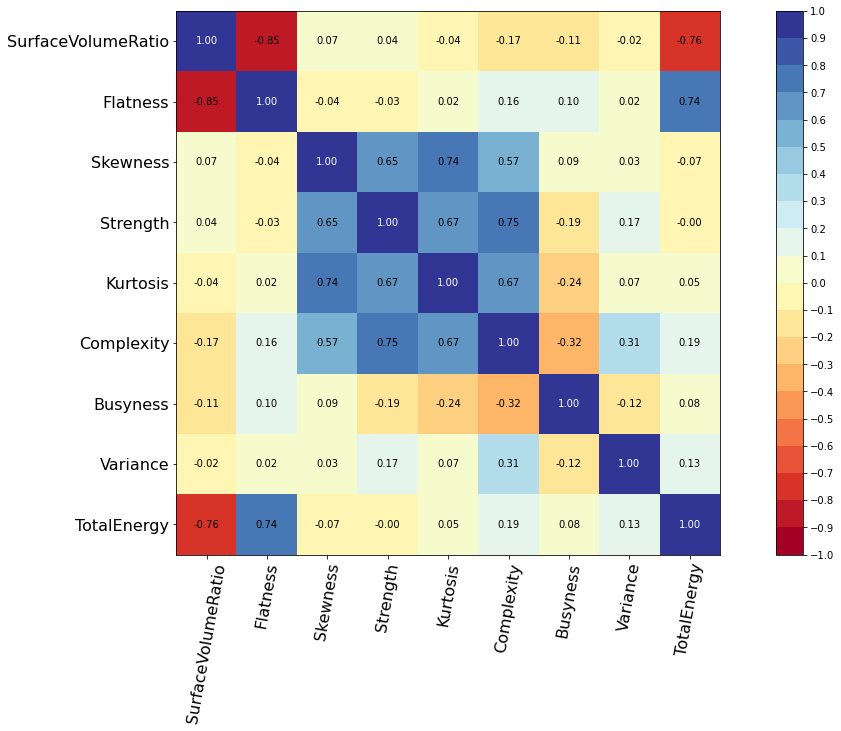

In [39]:
correlation_matrix(X_livertumor, figure_size=(20,10), text_fontsize=10)

In [40]:
test_livertumor_predictions = test_livertumor_data.loc[:, ['ScoutID', "HDFS_Time", "HDFS_Code", "Cancer_Type"]]
test_livertumor_predictions['Prediction'] = livertumor_riskpreds
test_livertumor_predictions.to_excel(os.path.join(data_folder, "RSF_test_liver_tumor_predictions_80_20_041922.xlsx"), index=False)

# Other Code

In [ ]:
# correlation_matrix(X_liver, figure_size=(30,15), text_fontsize=10)